In [143]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()

role = sagemaker.get_execution_role()
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
filepath = './data/stockprices.csv'
data = pd.read_csv(filepath)
# data = data.sort_values('Date')

./data/UNH_2006-01-01_to_2018-01-01.csv
./data/PFE_2006-01-01_to_2018-01-01.csv
./data/BA_2006-01-01_to_2018-01-01.csv
./data/stockprices.csv
./data/all_stocks_2006-01-01_to_2018-01-01.csv
./data/PG_2006-01-01_to_2018-01-01.csv
./data/MMM_2006-01-01_to_2018-01-01.csv
./data/JPM_2006-01-01_to_2018-01-01.csv
./data/AABA_2006-01-01_to_2018-01-01.csv
./data/CVX_2006-01-01_to_2018-01-01.csv
./data/all_stocks_2017-01-01_to_2018-01-01.csv
./data/UTX_2006-01-01_to_2018-01-01.csv
./data/AXP_2006-01-01_to_2018-01-01.csv
./data/GE_2006-01-01_to_2018-01-01.csv
./data/TRV_2006-01-01_to_2018-01-01.csv
./data/HD_2006-01-01_to_2018-01-01.csv
./data/MCD_2006-01-01_to_2018-01-01.csv
./data/XOM_2006-01-01_to_2018-01-01.csv
./data/VZ_2006-01-01_to_2018-01-01.csv
./data/DIS_2006-01-01_to_2018-01-01.csv
./data/CAT_2006-01-01_to_2018-01-01.csv
./data/CSCO_2006-01-01_to_2018-01-01.csv
./data/WMT_2006-01-01_to_2018-01-01.csv
./data/GOOGL_2006-01-01_to_2018-01-01.csv
./data/IBM_2006-01-01_to_2018-01-01.csv
./da

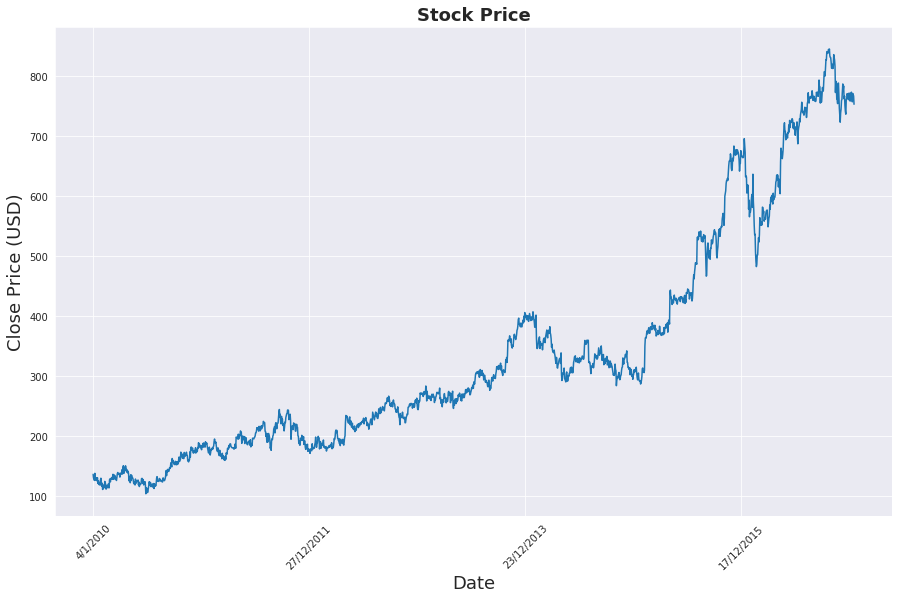

In [144]:
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()
price = data[['Close']]


In [145]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 

        data.append(data_raw[index: index + lookback])
        
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 5 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
price.to_numpy()[0:5]

x_train.shape =  (1406, 4, 1)
y_train.shape =  (1406, 1)
x_test.shape =  (351, 4, 1)
y_test.shape =  (351, 1)


array([[-0.91248866],
       [-0.92933727],
       [-0.9320509 ],
       [-0.94002002],
       [-0.90824265]])

In [20]:
train_input = sagemaker_session.upload_data("data")
train_input

's3://sagemaker-ap-southeast-1-205124155157/data'

In [147]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [95]:
from sagemaker.pytorch import PyTorch


hyperparameters={"epochs":"100"}

estimator = PyTorch(
    entry_point="source/train2.py",
    role=role,
    framework_version="1.6.0",
    py_version='py3',
    instance_count=1,
    instance_type="ml.c5.xlarge",

)

estimator.fit({'train': train_input})

2022-02-20 16:10:39 Starting - Starting the training job...
2022-02-20 16:11:02 Starting - Preparing the instances for trainingProfilerReport-1645373439: InProgress
......
2022-02-20 16:12:03 Downloading - Downloading input data...
2022-02-20 16:12:23 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-20 16:12:50,704 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-20 16:12:50,706 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-20 16:12:50,719 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-20 16:12:50,724 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-20 16:12:51,025 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-20 16:12:51,036 sagemaker-training-toolkit

In [97]:
deployment = estimator.deploy(initial_instance_count=1,instance_type='ml.m5.xlarge',endpoint_name='pytorch-bring-your-own-script-endpoint')
# estimator.update_endpoint(initial_instance_count=1,instance_type='ml.m5.xlarge',endpoint_name='pytorch-bring-your-own-script-endpoint')


-----!

In [148]:
from sagemaker.predictor import Predictor
deployment = Predictor(endpoint_name="pytorch-inference-2022-02-21-14-59-37-003")

In [149]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


In [150]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [151]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.0006387963076122105
Epoch  1 MSE:  0.0014176766853779554
Epoch  2 MSE:  0.0665803849697113
Epoch  3 MSE:  0.0014460457023233175
Epoch  4 MSE:  0.020279232412576675
Epoch  5 MSE:  0.038614775985479355
Epoch  6 MSE:  0.03208482265472412
Epoch  7 MSE:  0.01524314098060131
Epoch  8 MSE:  0.003711479716002941
Epoch  9 MSE:  0.006207623984664679
Epoch  10 MSE:  0.016351398080587387
Epoch  11 MSE:  0.018966948613524437
Epoch  12 MSE:  0.012197277508676052
Epoch  13 MSE:  0.004941349849104881
Epoch  14 MSE:  0.0030950659420341253
Epoch  15 MSE:  0.005732319317758083
Epoch  16 MSE:  0.008860492147505283
Epoch  17 MSE:  0.00942771602421999
Epoch  18 MSE:  0.006928146816790104
Epoch  19 MSE:  0.0031539234332740307
Epoch  20 MSE:  0.0008496742229908705
Epoch  21 MSE:  0.0016019876347854733
Epoch  22 MSE:  0.004104264080524445
Epoch  23 MSE:  0.005248771049082279
Epoch  24 MSE:  0.0038230991922318935
Epoch  25 MSE:  0.001743498258292675
Epoch  26 MSE:  0.0012163675855845213
Epoch  

In [152]:


predict = pd.DataFrame(scaler.inverse_transform(x_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))


In [153]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = deployment.predict(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
lstm = []

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: tensor([[[0.1811],
         [0.1540],
         [0.1349],
         [0.1392]],

        [[0.1540],
         [0.1349],
         [0.1392],
         [0.1542]],

        [[0.1349],
         [0.1392],
         [0.1542],
         [0.1321]],

        ...,

        [[0.8034],
         [0.8056],
         [0.7855],
         [0.7623]],

        [[0.8056],
         [0.7855],
         [0.7623],
         [0.8002]],

        [[0.7855],
         [0.7623],
         [0.8002],
         [0.7932]]]), type: <class 'torch.Tensor'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [125]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
# !pip install nbformat
# !pip install plotly
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
# fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
#                     mode='lines',
#                     name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)


In [130]:
# !pip install chart-studio

In [154]:
import chart_studio.plotly as py
import chart_studio

chart_studio.tools.set_credentials_file(username='awsryanlee', api_key='n9L15EdJiAQ6EAf2blmi')
py.iplot(fig, filename='stock_prediction_lstm')

PlotlyRequestError: No message